## Analizador de Sentimientos con un modelo de Regresión Logística

In [1]:
# Leemos el archivo previamente generado con las opiniones en español y sus etiquetas

import pandas as pd
dataframe = pd.read_csv('../data/imbd_clean_es.csv')
dataframe.head(10)

clean_review_es  categoria
0  uno de los otros críticos ha mencionado que de...          1
1  una pequeña pequeña producciónla técnica de fi...          1
2  pensé que esta era una manera maravillosa de p...          1
3  básicamente hay una familia donde un niño pequ...          0
4  el amor en el tiempo de petter mattei es una p...          1
5  probablemente mi película favorita de todos lo...          1
6  seguro que me gustaría ver una resurrección de...          1
7  este espectáculo fue una idea increíble fresca...          0
8  alentados por los comentarios positivos sobre ...          0
9  si te gusta la risa original desgarradora te g...          1

In [2]:
# Carga de los textos y categorias a variables Python
opiniones_data = dataframe['clean_review_es'].to_list()
opiniones_target = dataframe['categoria'].to_list()

In [3]:
# Vectorización de los datos
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(binary=True)
cv.fit(opiniones_data)
opiniones_data = cv.transform(opiniones_data)

In [4]:
# Clasificador - 70% para entrenar, 15% para validar, 15 para probar
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = \
    train_test_split(opiniones_data, opiniones_target, test_size=0.3, random_state=0)
X_val, X_test, y_val, y_test = \
    train_test_split(X_test, y_test, test_size=0.5, random_state=0)

In [5]:
# Probando parámetros para crear el mejor modelo acorde a lo observado

for c in [0.01, 0.05, 0.25, 0.5, 1]: # probando diferentes valores de 
    # C := Regularization applied a penalty to increasing the magnitude of parameter values in order to reduce overfitting
    lr = LogisticRegression(C=c, penalty='l2', max_iter=350)
    lr.fit(X_train, y_train)
    print ("Accuracy for C=%s: %s" 
           % (c, accuracy_score(y_val, lr.predict(X_val))))
    
# Accuracy for C=0.01: 0.8559
# Accuracy for C=0.05: 0.8659
# Accuracy for C=0.25: 0.8637
# Accuracy for C=0.5: 0.8608
# Accuracy for C=1: 0.8605

Accuracy for C=0.01: 0.8630666666666666
Accuracy for C=0.05: 0.8749333333333333
Accuracy for C=0.25: 0.8728
Accuracy for C=0.5: 0.8725333333333334
Accuracy for C=1: 0.8713333333333333


In [6]:
# El modelo final con los mejores parámetros obtenidos
final_model = LogisticRegression(C=0.05, penalty='l2', max_iter=350) # C=0.05 arroja mejor resultado
final_model.fit(X_train, y_train)
# Validación con los datos que el modelo no conoce; X_test
print ("Final Accuracy: %s" 
       % accuracy_score(y_test, final_model.predict(X_test)))
# Final Accuracy: 0.8641333333333333

Final Accuracy: 0.8641333333333333


In [7]:
# Creando las funciones para tomar los mejores y peores tokens de cada categoría

feature_to_coef = {
    word: coef for word, coef in zip(
        cv.get_feature_names_out(), final_model.coef_[0]
    )
}

positivos = []
negativos = []

for more_positive in sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1], 
    reverse=True)[:12]:
    if not more_positive[0].isdigit():
        positivos.append(more_positive)

for more_negative in sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1])[:11]:
    if not more_negative[0].isdigit():
        negativos.append(more_negative)

print('Los tokens mejor y peor calificados')
for i in range(len(positivos)):
    print(f'{positivos[i][0]:>16} = {round(positivos[i][1], 4):<8} {negativos[i][0]:>13} = {round(negativos[i][1], 4)}')

Los tokens mejor y peor calificados
       excelente = 0.9421            peor = -1.2856
         encantó = 0.7562          peores = -1.2677
        perfecto = 0.7411        horrible = -1.0162
            gema = 0.6788        terrible = -0.9928
      sorprendió = 0.6734        aburrida = -0.957
maravillosamente = 0.6319            mala = -0.9249
     refrescante = 0.6243       decepción = -0.8775
        favorita = 0.6039   decepcionante = -0.7743
        disfruté = 0.5999        aburrido = -0.7668
         encanta = 0.597      desperdicio = -0.7219


## Métricas

### Matriz de confusión

In [8]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix
from matplotlib import axes
import matplotlib.pyplot as plt

train_predictions = cross_val_predict(final_model, X_train, y_train, cv=3)
print(f'Predicciones realizadas: {train_predictions.shape[0]}')

# Cree la matriz de confusión
cm = confusion_matrix(y_train, train_predictions)
# print(f'Matriz de confusión:\n {cm}')
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=final_model.classes_)
# disp1 = ConfusionMatrixDisplay.from_estimator(final_model, X_train, y_train)

Predicciones realizadas: 35000


In [9]:
print(f'train_predictions.shape(): {train_predictions.shape[0]}')

train_predictions.shape(): 35000


[Text(0.5, 0, 'Dato predicho'), Text(0, 0.5, 'Dato real')]

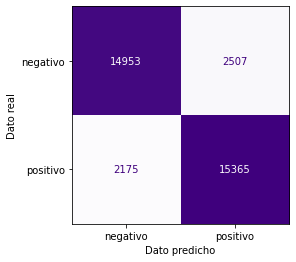

In [10]:
cmd = ConfusionMatrixDisplay(cm, display_labels=['negativo','positivo'])
cmd.plot(cmap='Purples', colorbar=False)
cmd.ax_.set(xlabel='Dato predicho', ylabel='Dato real')
# disp.plot(cmap='Purples', colorbar=False)

In [11]:
# Impresión de procentaje de Accuracy del modelo
print("Accuracy del modelo: ")
print(metrics.accuracy_score(y_train, train_predictions))

Accuracy del modelo: 
0.8662285714285715


In [12]:
# Impresión de las métricas para el modelo
print("\nMétricas de evaluación:")
print(classification_report(y_train, train_predictions))


Métricas de evaluación:
              precision    recall  f1-score   support

           0       0.87      0.86      0.86     17460
           1       0.86      0.88      0.87     17540

    accuracy                           0.87     35000
   macro avg       0.87      0.87      0.87     35000
weighted avg       0.87      0.87      0.87     35000



### Curva ROC

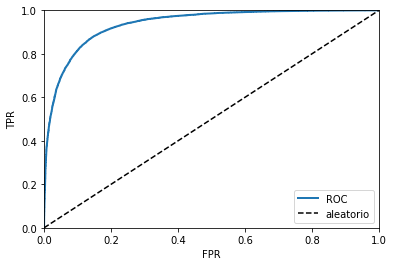

AUC: 0.938


In [13]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

y_scores = cross_val_predict(final_model, X_train, y_train, cv=3,
                             method="decision_function")
fpr, tpr, thresholds = roc_curve(y_train, y_scores)

# Plot Curva ROC
plt.plot(fpr, tpr, linewidth=2, label="ROC")
plt.plot([0, 1], [0, 1], 'k--', label="aleatorio")
plt.axis([0, 1, 0, 1])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.show()

# Área bajo la curva
auc = roc_auc_score(y_train, y_scores)
print("AUC: %.3f"% auc)